加载数据

In [1]:
import para
import csv
import numpy as np
import matplotlib.pyplot as plt

# print(t)
for i in range(para.machine_num):
    file_path = para.train_data +  '{0:03d}'.format(i+1) + '/201807.csv'
    with open(file_path,'r') as file:
        data = csv.reader(file)
        data.__next__()
        full_data = []
        p_miss_data = []
        for record in data:
            if any([r==''for r in record]):
                p_miss_data.append(record)
            else:
                full_data.append(record)
        raw_data_str = full_data
    
    break
    
# record to be filled
file_path = para.train_data+'template_submit_result.csv'
all_miss_data = []
with open(file_path,'r') as file:
    data = csv.reader(file)
    data.__next__()
    for record in data:
        if record[1] == '1':
            all_miss_data.append(record)

无缺失字段记录

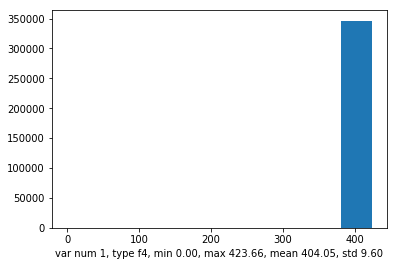

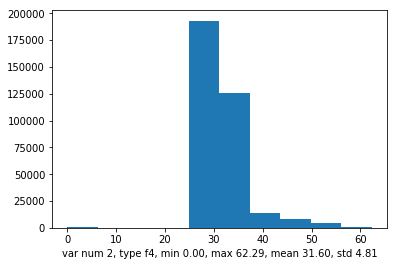

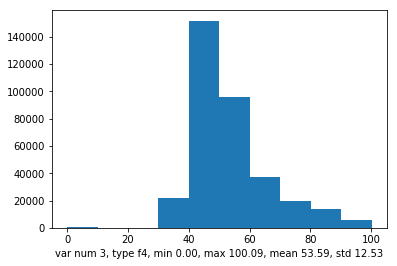

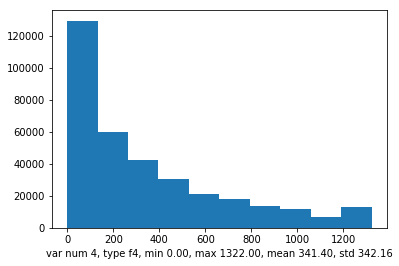

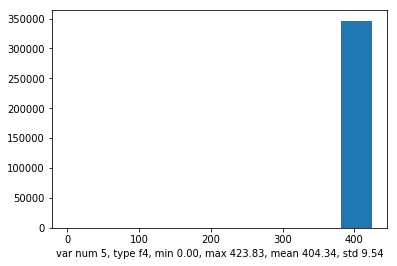

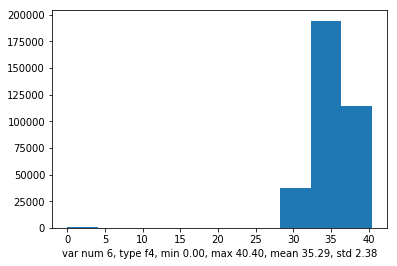

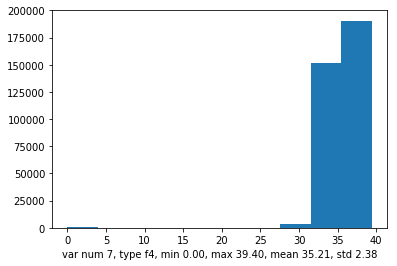

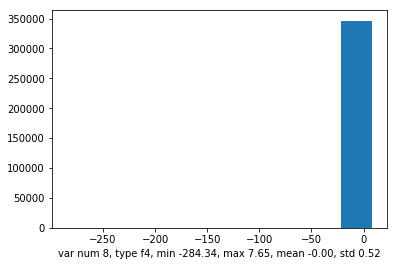

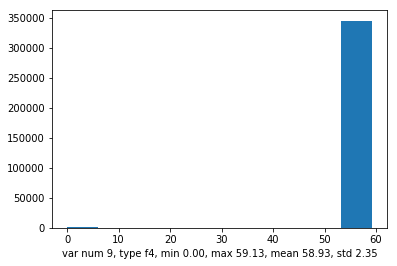

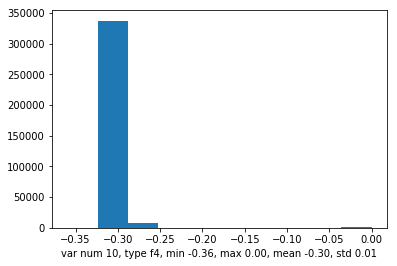

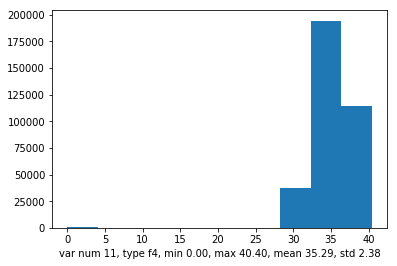

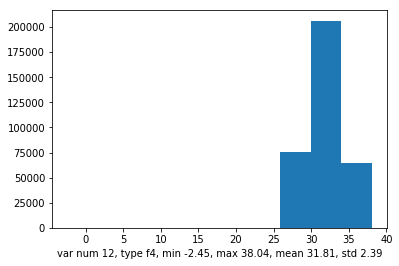

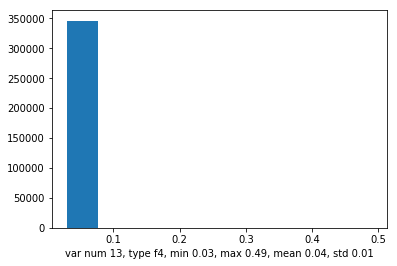

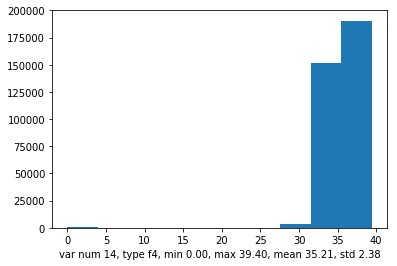

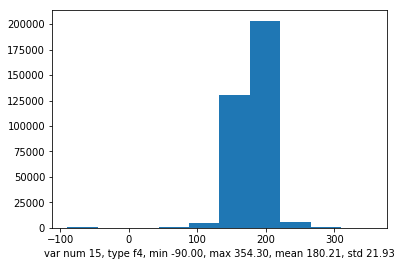

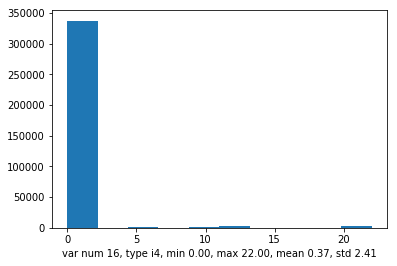

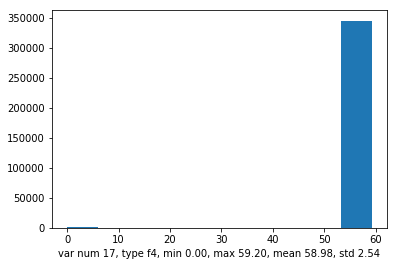

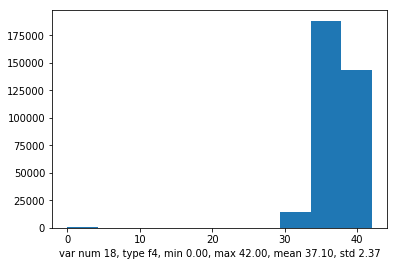

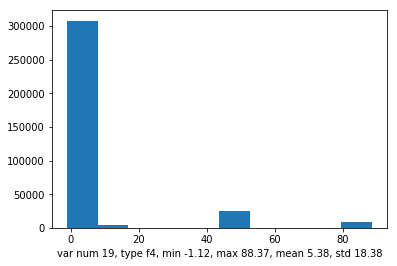

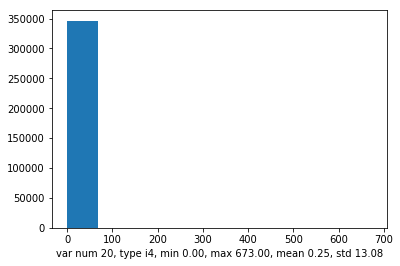

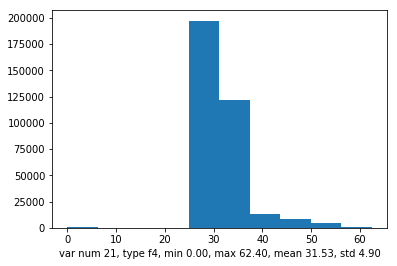

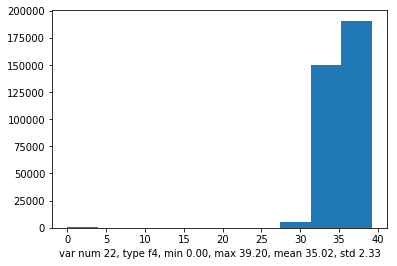

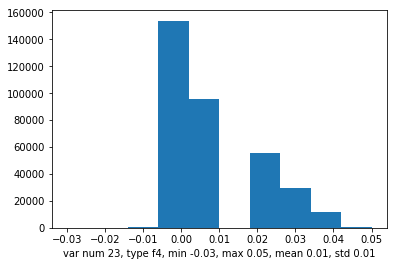

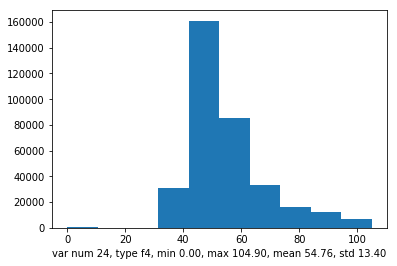

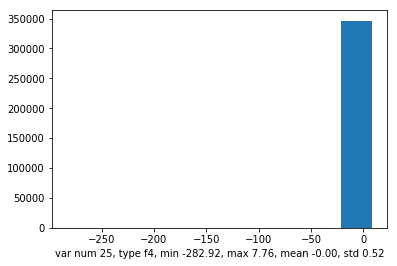

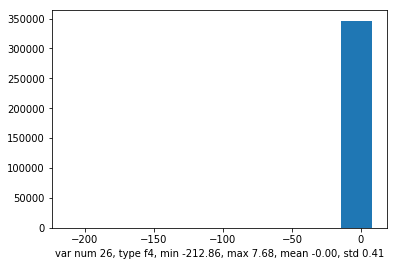

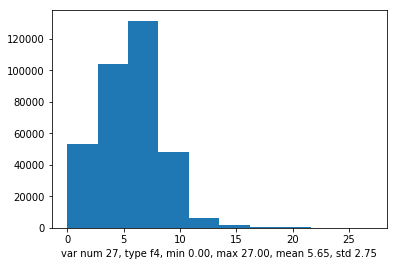

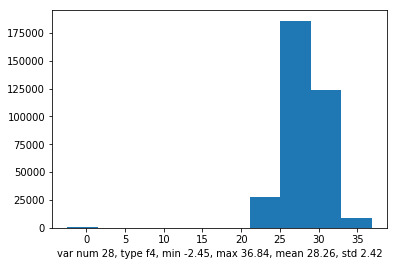

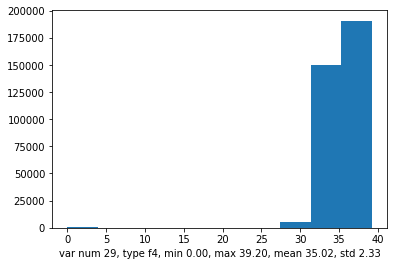

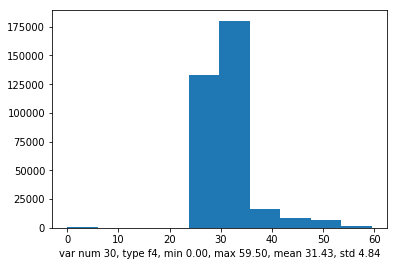

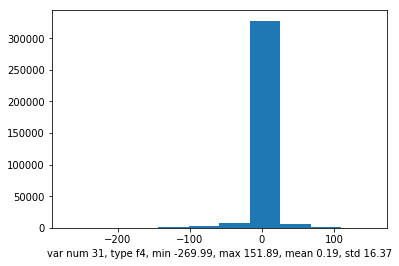

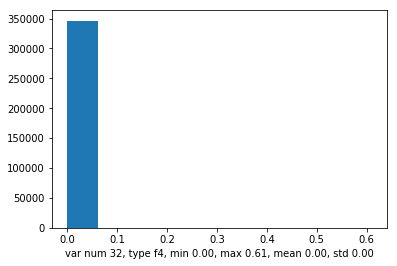

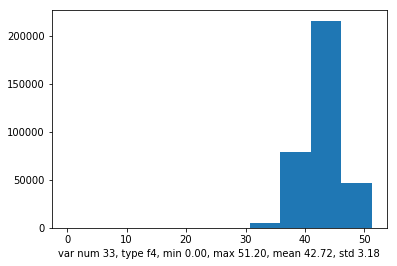

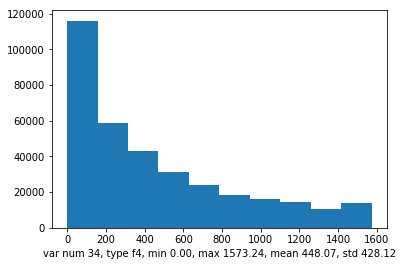

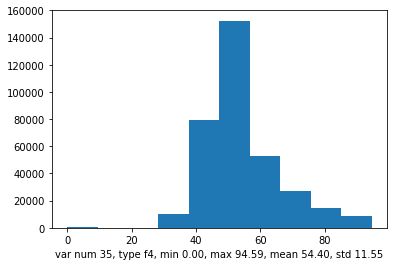

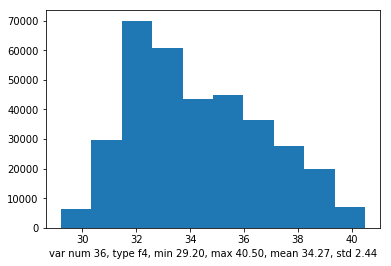

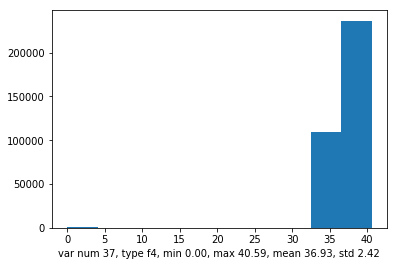

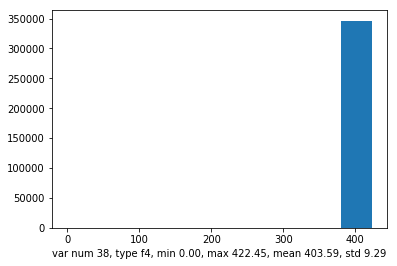

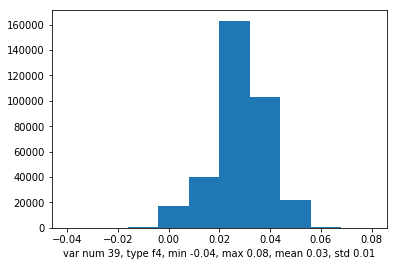

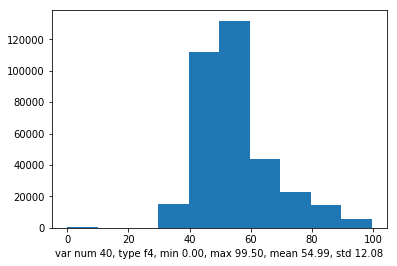

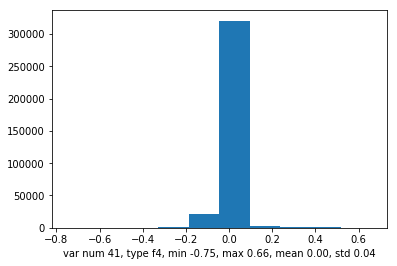

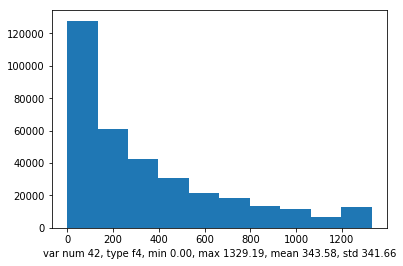

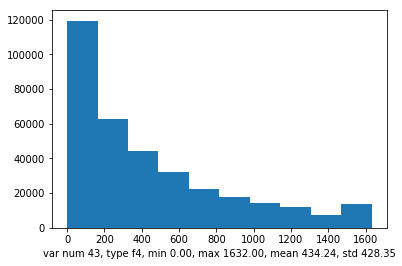

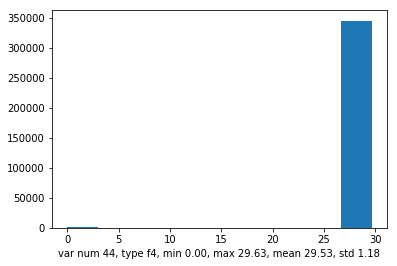

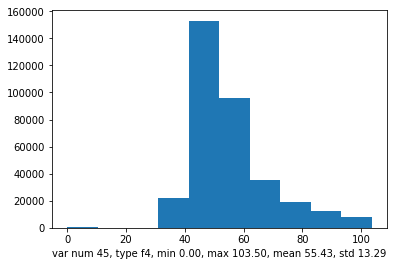

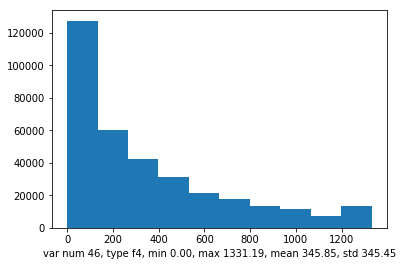

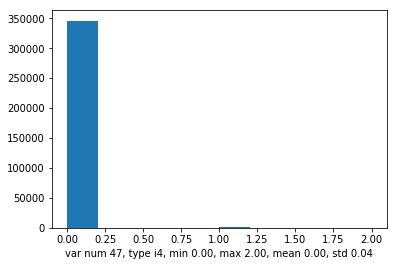

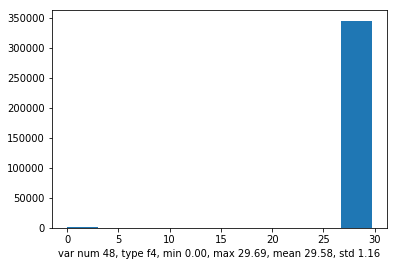

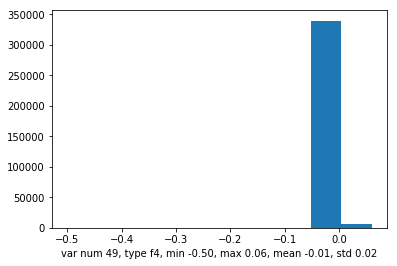

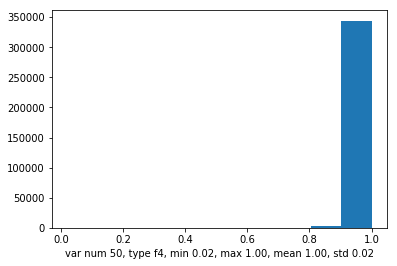

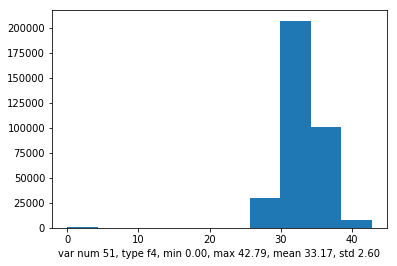

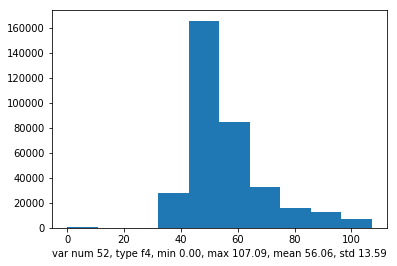

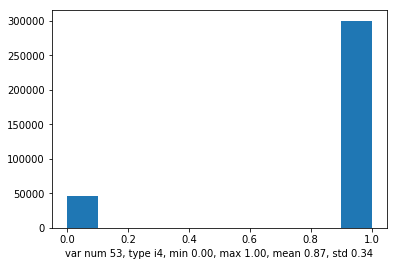

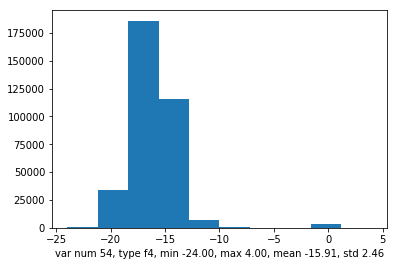

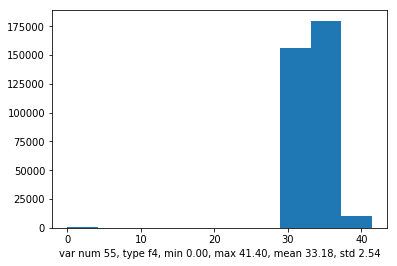

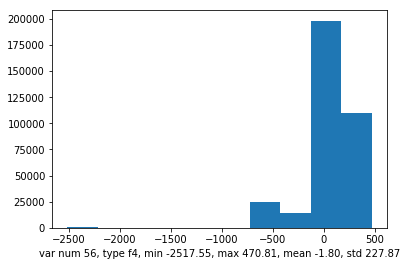

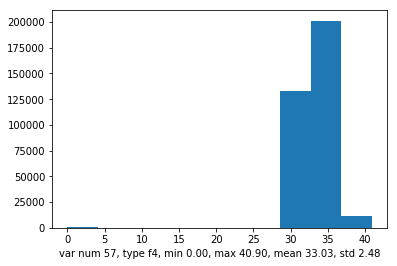

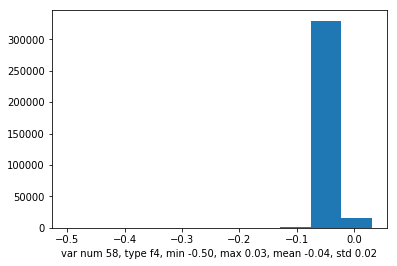

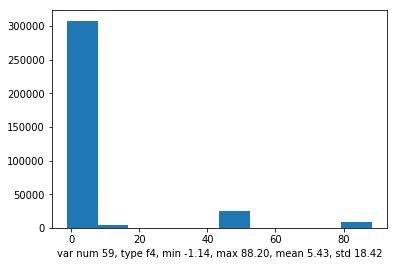

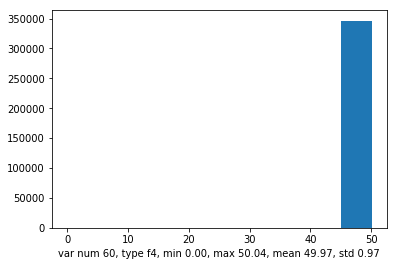

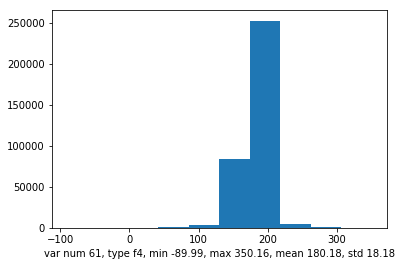

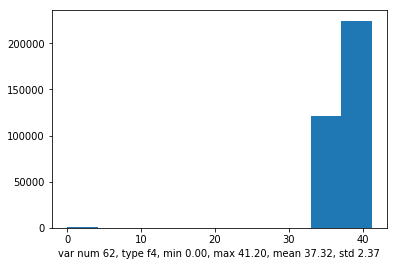

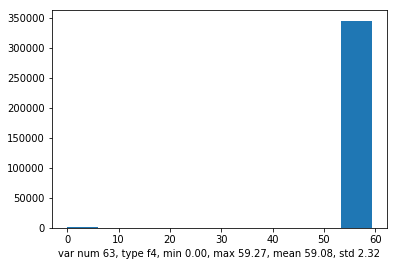

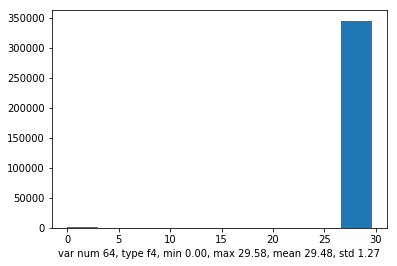

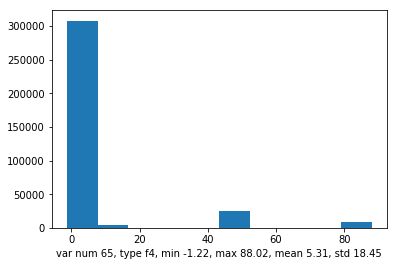

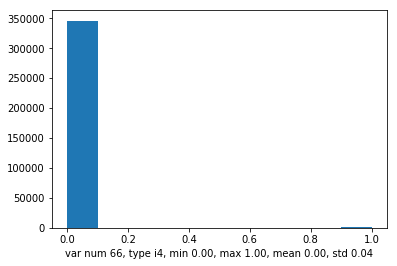

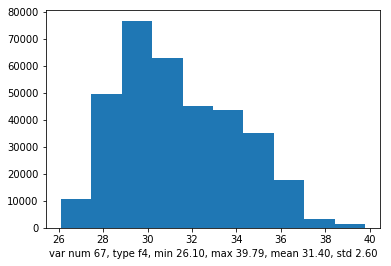

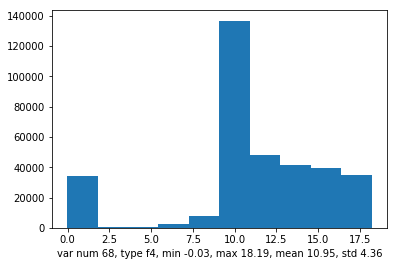

In [2]:
%matplotlib inline
t = ['M'] + ['i4'] + ['f4']*15+['i4']+['f4']*3+['i4']+['f4']*26+['i4']+['f4']*5+['i4']+['f4']*12+['i4']+['f4']*2

raw_data_str = np.array(raw_data_str)
raw_data = []

for i in range(70):
    s = raw_data_str[:,i].astype(t[i])
    if i != 0 and i !=1:
        plt.figure()
        plt.hist(s)
        plt.xlabel('var num {0}, type {5}, min {1:.2f}, max {2:.2f}, mean {3:.2f}, std {4:.2f}'.format(i-1,np.min(s),np.max(s),np.mean(s),np.std(s),t[i]))
        plt.show()
    raw_data.append(s)
#     print(s[0],s.dtype)

# print(raw_data[0],raw_data.dtype)

时序性测试

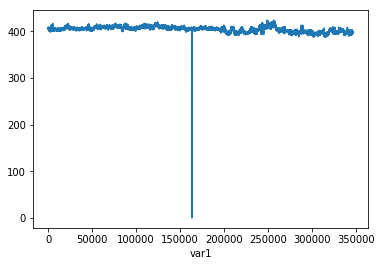

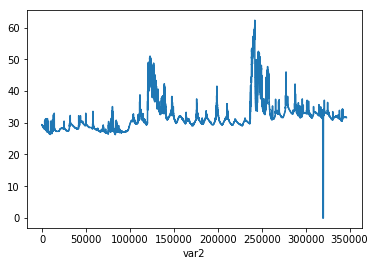

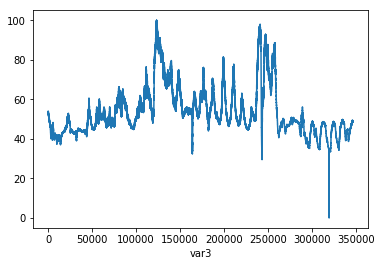

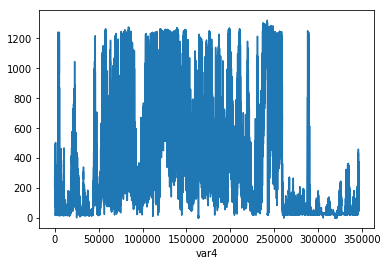

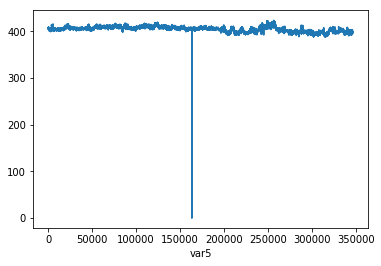

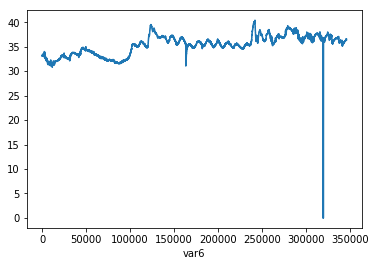

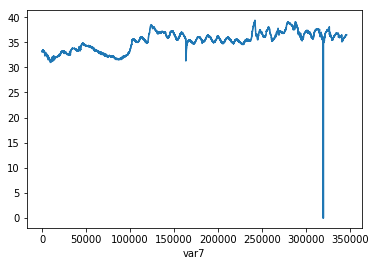

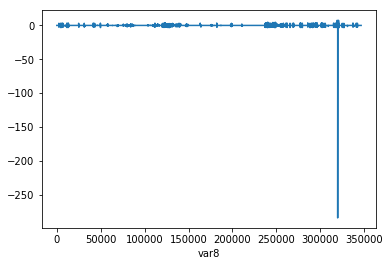

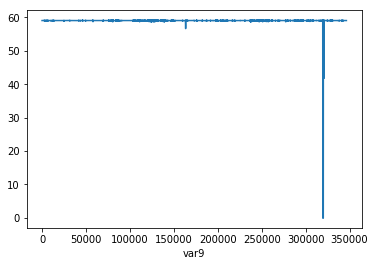

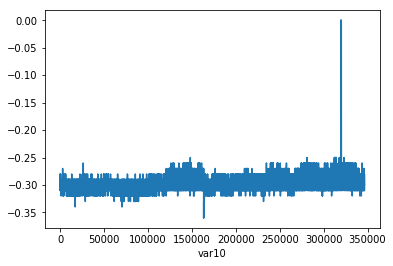

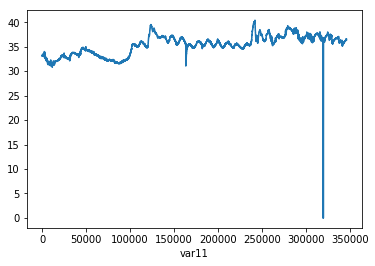

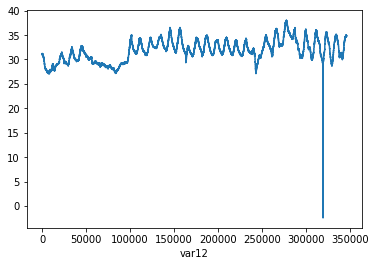

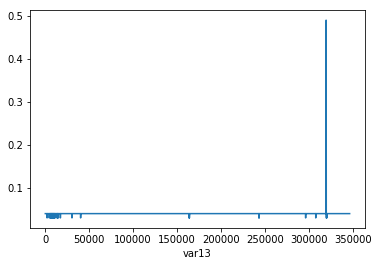

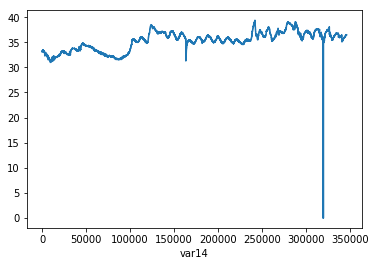

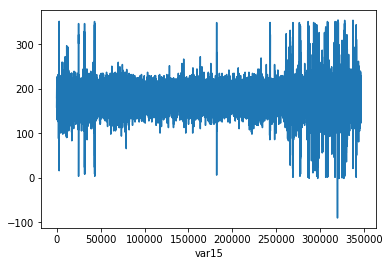

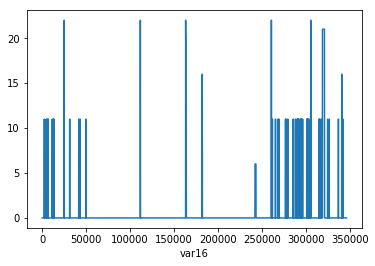

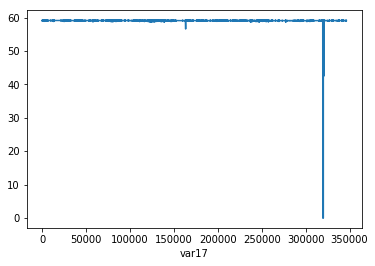

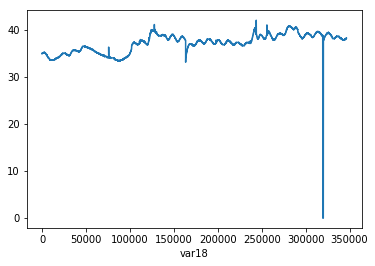

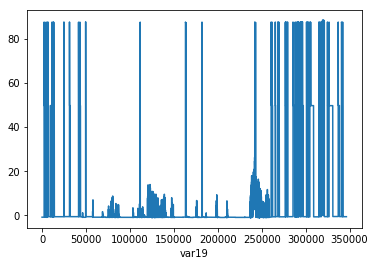

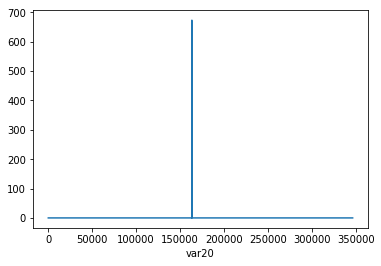

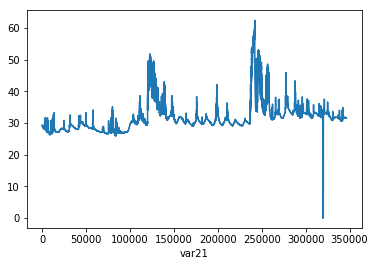

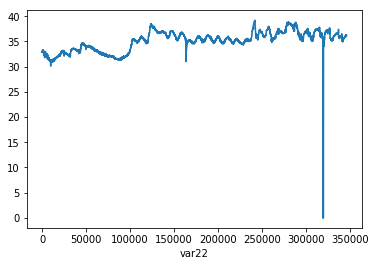

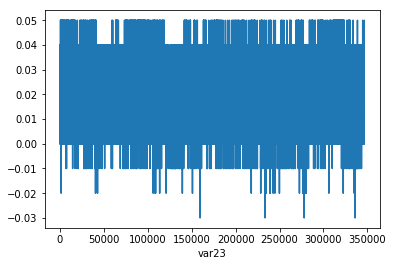

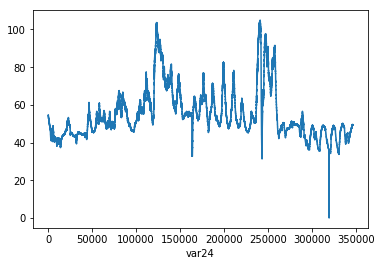

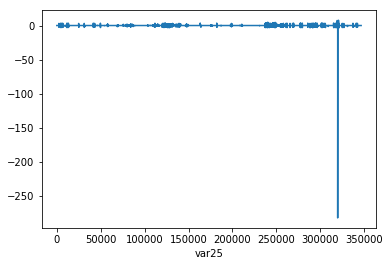

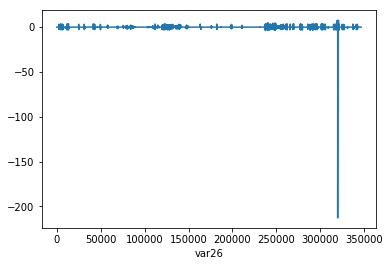

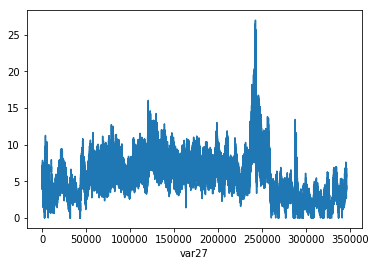

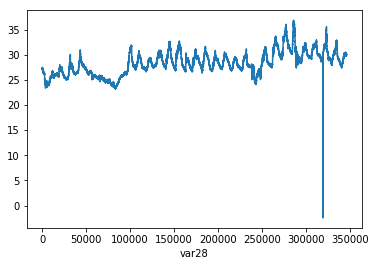

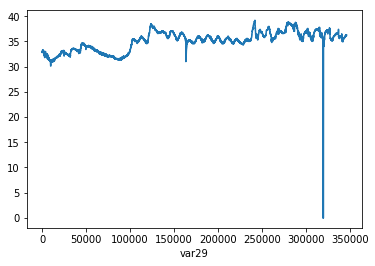

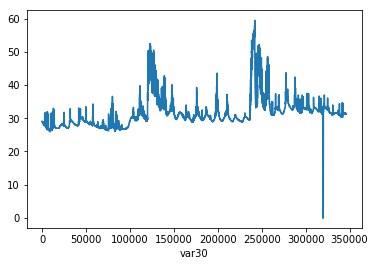

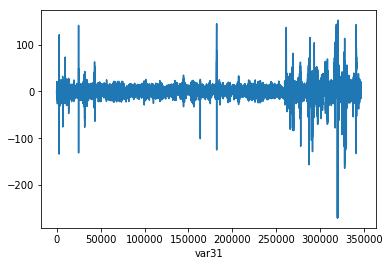

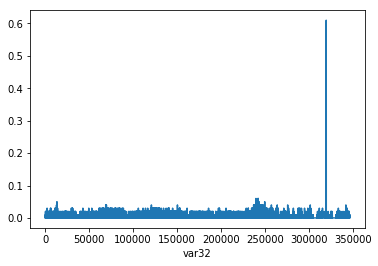

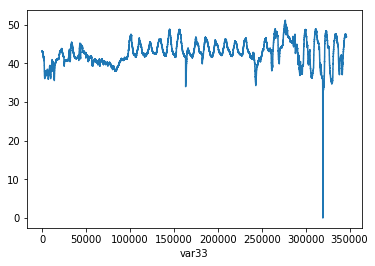

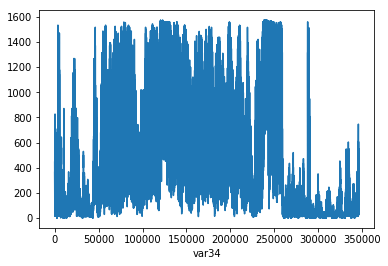

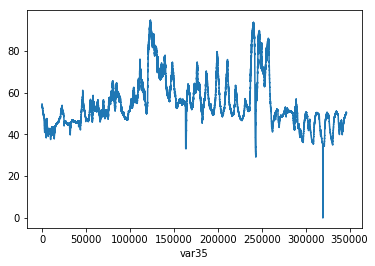

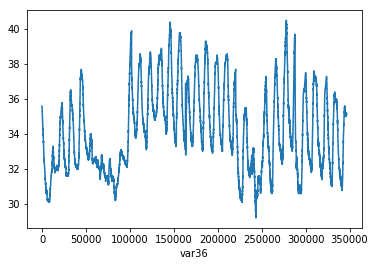

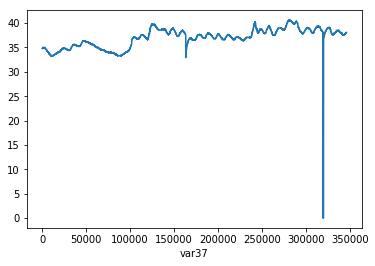

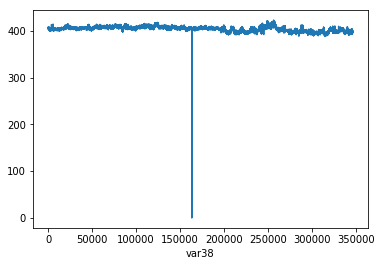

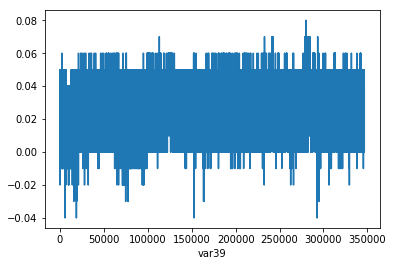

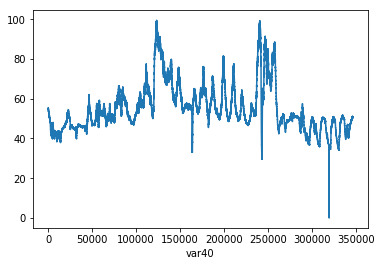

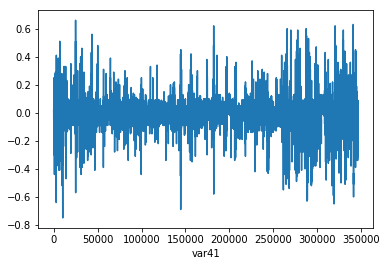

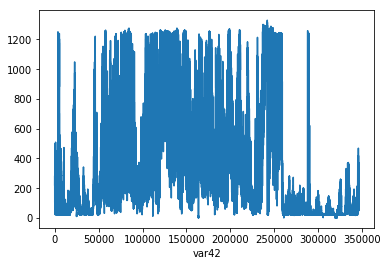

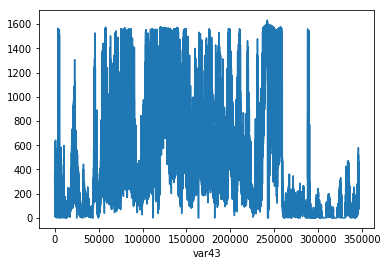

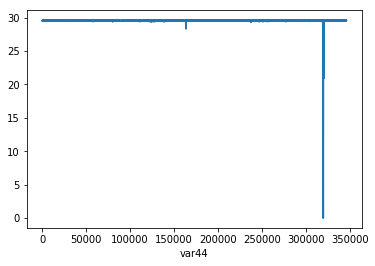

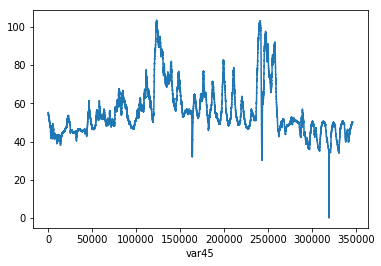

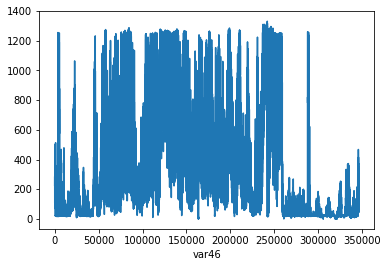

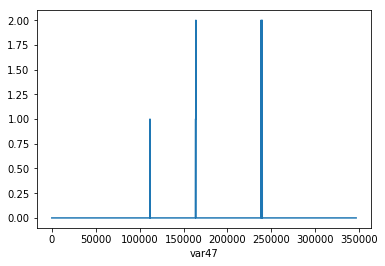

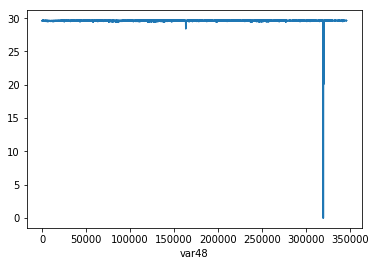

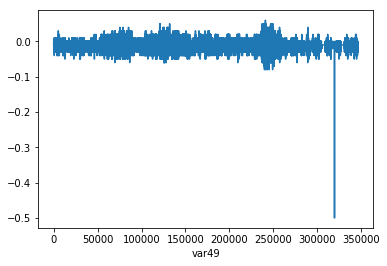

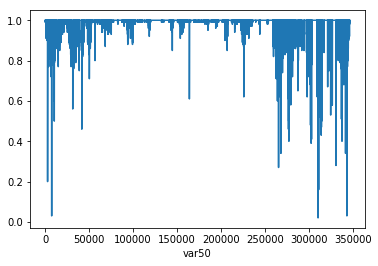

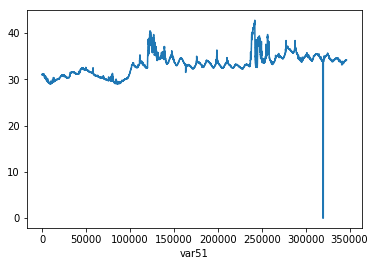

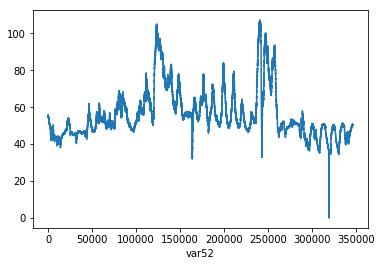

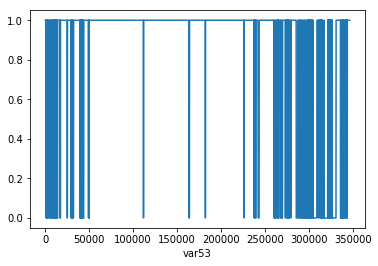

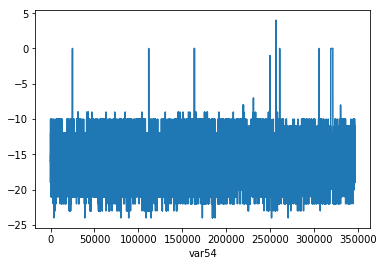

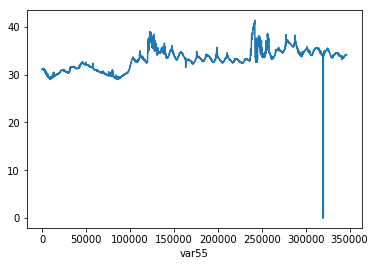

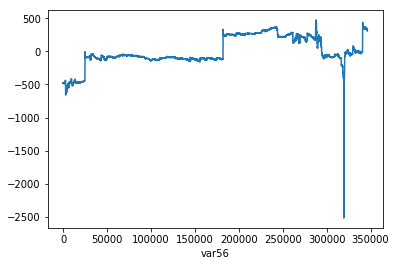

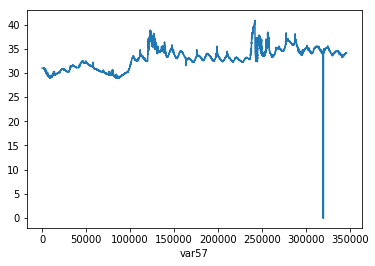

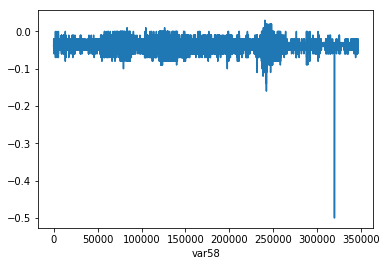

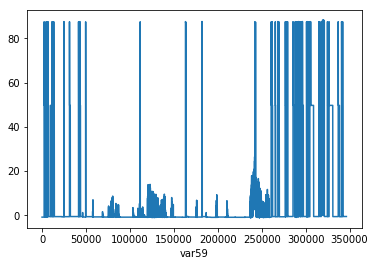

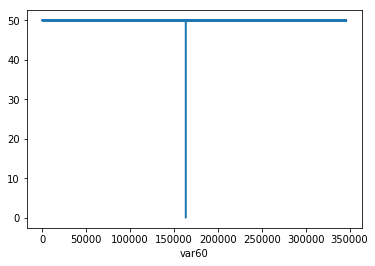

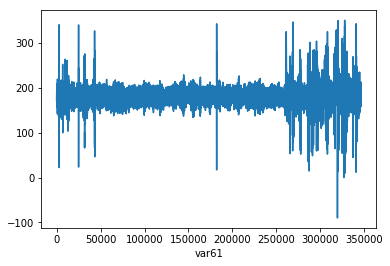

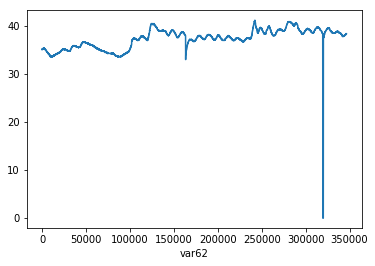

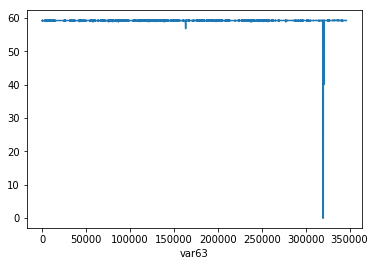

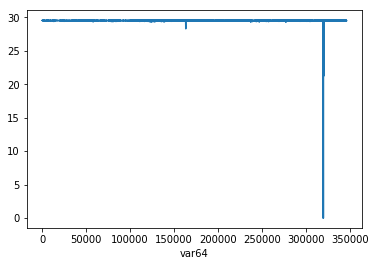

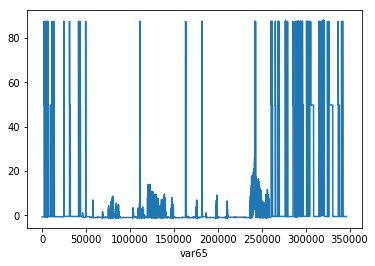

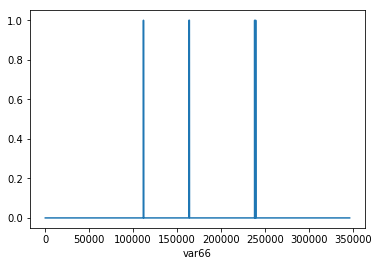

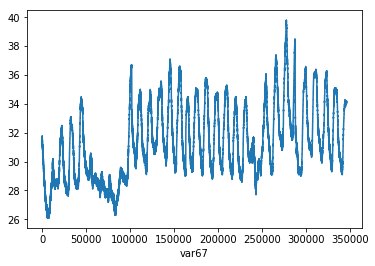

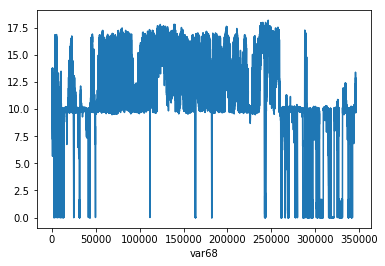

In [3]:
# plt.figure(figsize=(16,8))
for i in range(2,70):
    plt.plot(raw_data[i],label=str(i-1))
    plt.xlabel('var'+str(i-1))
    plt.show()

有缺失字段记录

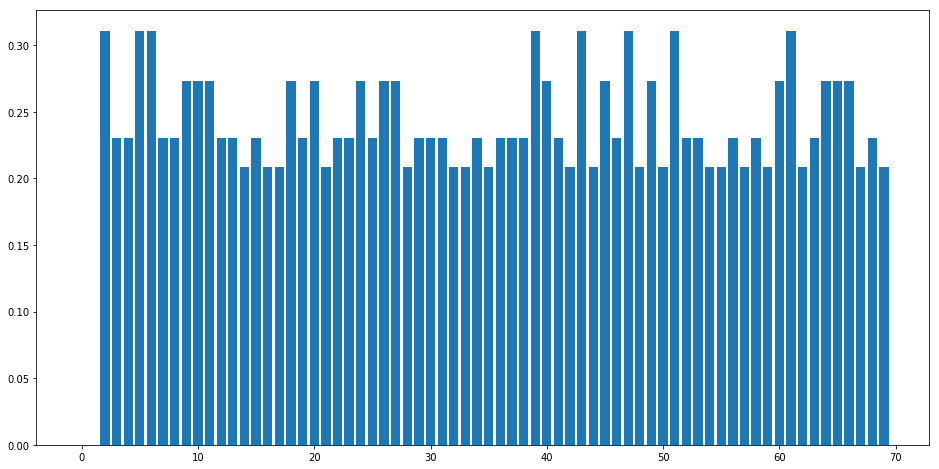

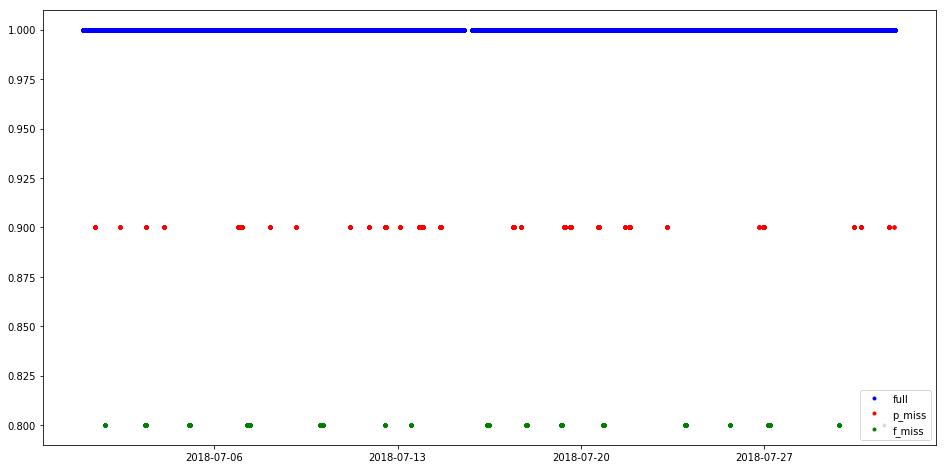

In [4]:
p_miss_count = [0 for _ in range(70)]
p_miss_total = len(p_miss_data)
# print(p_miss_total)
for r in p_miss_data:
    for i in range(len(r)):
        if r[i]=='':
            p_miss_count[i]+=1
p_miss_count = np.array(p_miss_count)
plt.figure(figsize=(16,8))
plt.bar(np.array(range(70)),p_miss_count/p_miss_total)
plt.show()

f_miss_t = []    
p_miss_t = []
for record in all_miss_data:
    flag = False
    for p_r in p_miss_data:
        if record[0]==p_r[0]:
            flag = True
            break
    if flag:
        p_miss_t.append(record[0])
    else:
        f_miss_t.append(record[0])    
plt.figure(figsize=(16,8))
plt.plot(raw_data[0],[1 for _ in range(len(raw_data[0]))],'b.',label='full')
plt.plot(np.array(p_miss_t,dtype='M'),[0.9 for _ in range(len(p_miss_t))],'r.',label='p_miss')
plt.plot(np.array(f_miss_t,dtype='M'),[0.8 for _ in range(len(f_miss_t))],'g.',label='f_miss')
plt.legend(loc='best')
plt.show()
    

预处理
1. 对float类型做standardization (x-mean)/std 
2. 对int，book类型做one_hot

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# class used for pre-process data 
class preproc:
    def __init__(self, data, types):
        self.features = [True if t=='f4' else False for t in types] # 68个字段预处理分类操作
        self.continuous, self.discrete = self.classify(data)
        self.proc_cont = self.standardization(self.continuous)
        self.proc_disc = self.one_hot(self.discrete)
        
    def classify(self, data):
        return data[:,self.features], data[:,np.logical_not(self.features)]
        
    def standardization(self, data):
        self.stda = StandardScaler()
        return self.stda.fit_transform(data)
        
    def one_hot(self,data):
        self.enc = OneHotEncoder()
        return self.enc.fit_transform(data)
        

In [52]:
#test
data = np.array(raw_data).T[:,2:]
pp = preproc(data,t[2:])
inputs = np.concatenate((pp.proc_cont,pp.proc_disc.todense()),axis=1)
print(inputs.shape)


/Users/jiayuzhai/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jiayuzhai/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jiayuzhai/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then y

(346449, 83)


模型

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, mid_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, mid_size)
        self.map4 = nn.Linear(mid_size, hidden_size)
        self.map5 = nn.Linear(hidden_size, hidden_size)
        self.map6 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        x = F.elu(self.map3(x))
        x = F.elu(self.map4(x))
        x = F.elu(self.map5(x))
        result = self.map3(x)
        return result

matrix([[ 1.37352053e-01, -4.59150593e-01,  2.43953542e-02,
         -3.60658784e-01,  1.26093241e-01, -9.27011996e-01,
         -8.88867524e-01,  1.98739091e-03,  4.58006391e-02,
         -1.01432234e-01, -9.27011996e-01, -2.79524542e-01,
         -2.44069751e-02, -8.88867524e-01,  2.63295240e-03,
          5.75473992e-02, -9.28663295e-01, -3.35863234e-01,
         -4.57761907e-01, -9.12702595e-01,  8.96543196e-01,
         -1.90261270e-02,  1.99036444e-03,  1.86803783e-03,
          1.70793717e-01, -3.37382346e-01, -9.12702595e-01,
         -4.80837223e-01,  4.67098424e-02, -3.60756812e-01,
          1.77906205e-01, -1.99981276e-01,  8.87297790e-03,
          5.41164505e-01, -8.84515667e-01,  9.95846520e-02,
         -6.55760060e-01,  1.71817573e-02,  4.51000579e-01,
         -3.55840564e-01, -3.27400793e-01,  3.53274136e-02,
         -2.58491990e-02, -3.45819168e-01,  2.53488842e-02,
         -6.39734913e-02,  2.41279362e-01, -8.35775987e-01,
         -4.10753067e-02, -3.78802201e-0

训练

In [ ]:
# if torch.cuda.is_available():
g = Generator(data.shape[1],hidden_size,mid_size,data.shape[1])

# for i in range():
# data_out = g(data)

In [41]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])
print(np.concatenate((a, b), axis=0))

print(np.concatenate((a, b.T), axis=1))

[[1 2]
 [3 4]
 [5 6]]
[[1 2 5]
 [3 4 6]]
